# Time travel

## Review

We disussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing and re-playing from past states. 

We call this `time travel`.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

Let's build out agent.

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [ ]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1111"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [ ]:
all_states = [s for s in graph.get_state_history(thread)]

In [ ]:
len(all_states)

The first element is the current state, just as we got from `get_state`.

In [ ]:
all_states[0]

Everything above we can visualize here: 

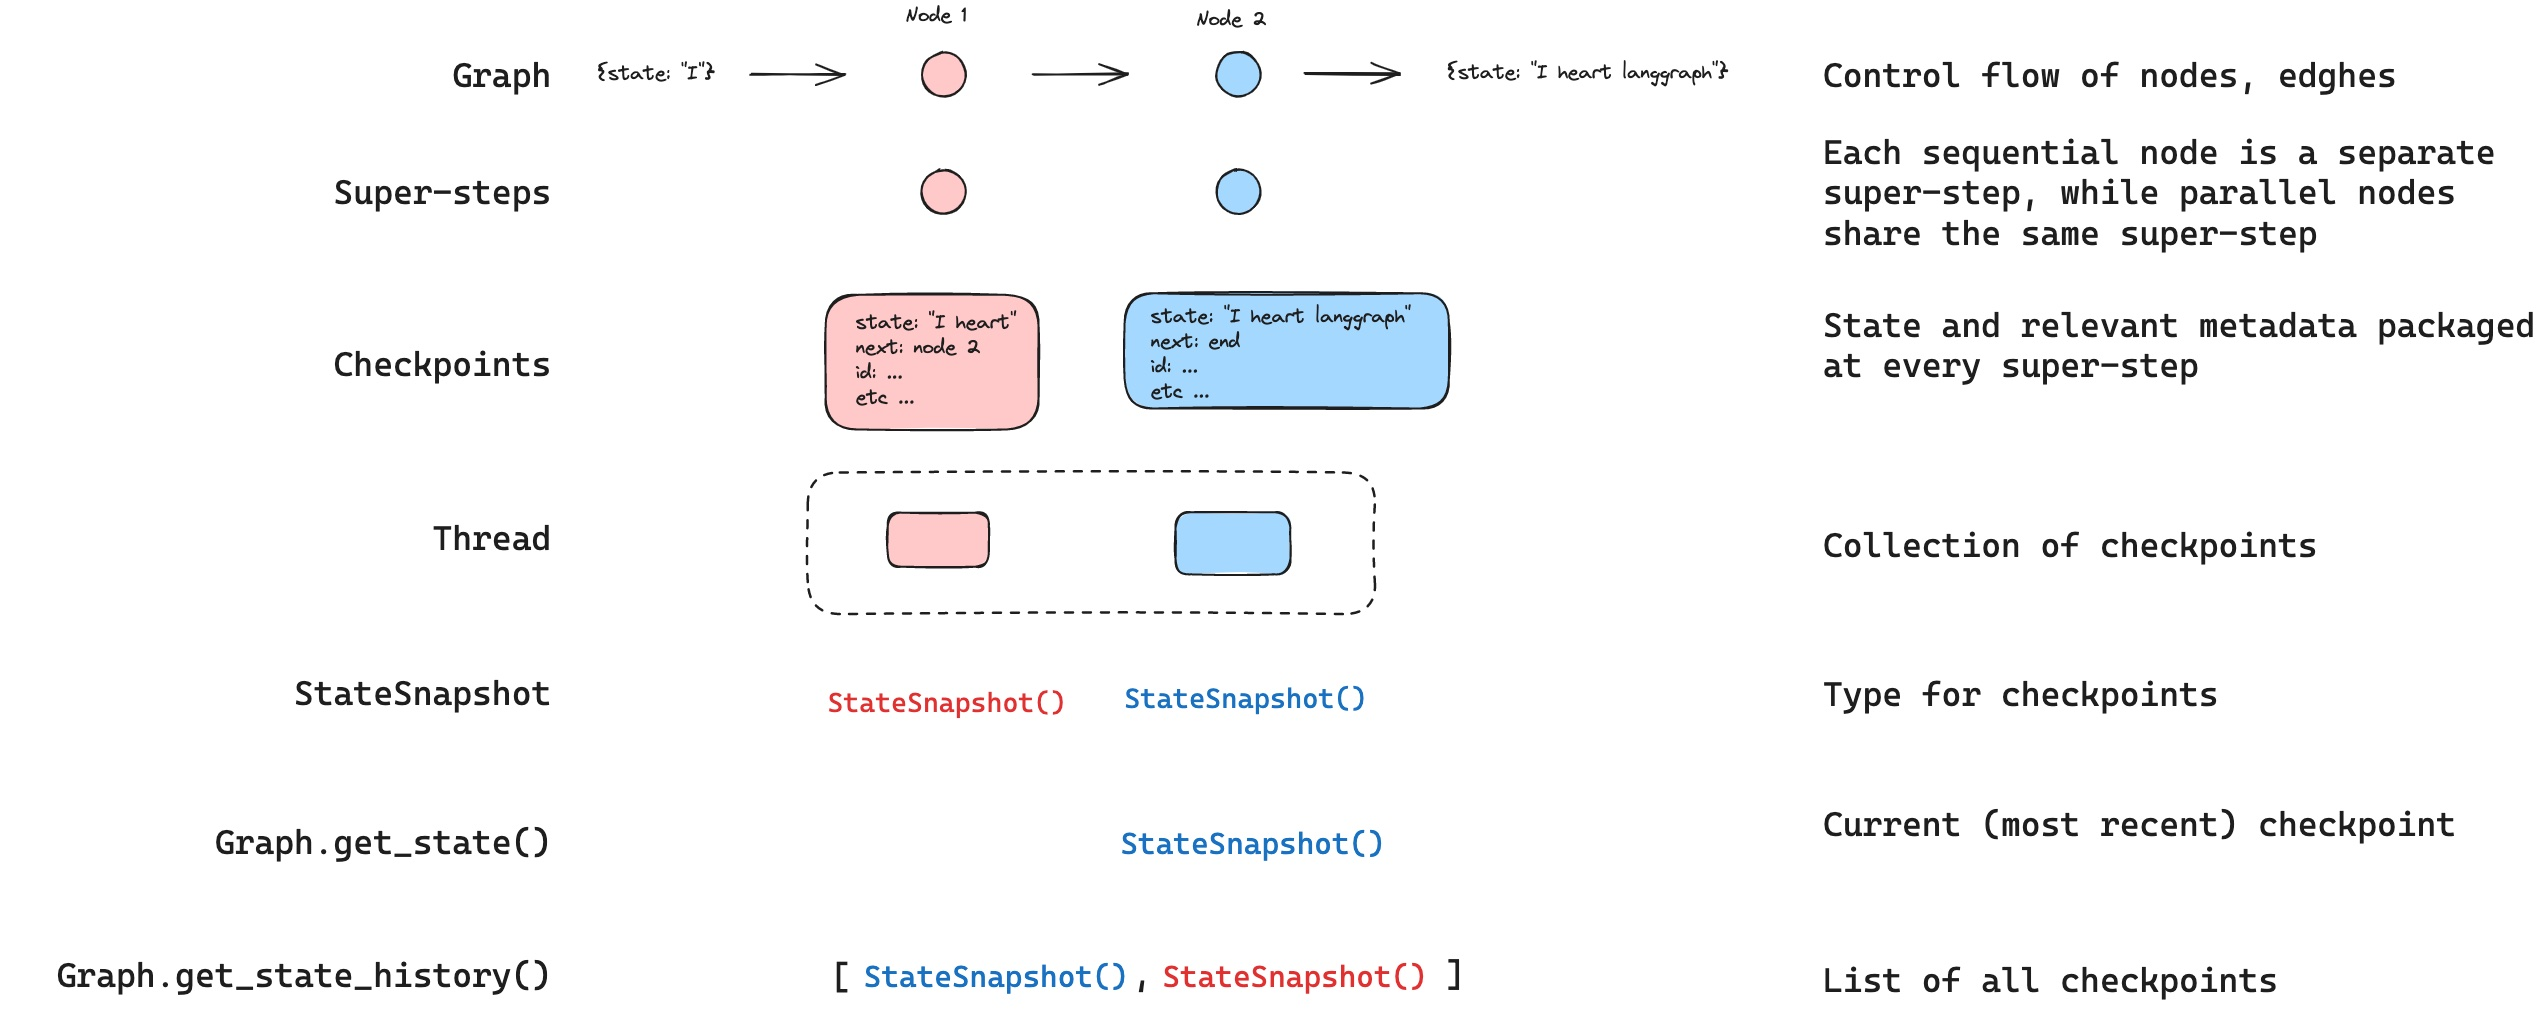

## Replaying 

We can re-run our agent from any of the prior steps.

This is the concept of time travel.

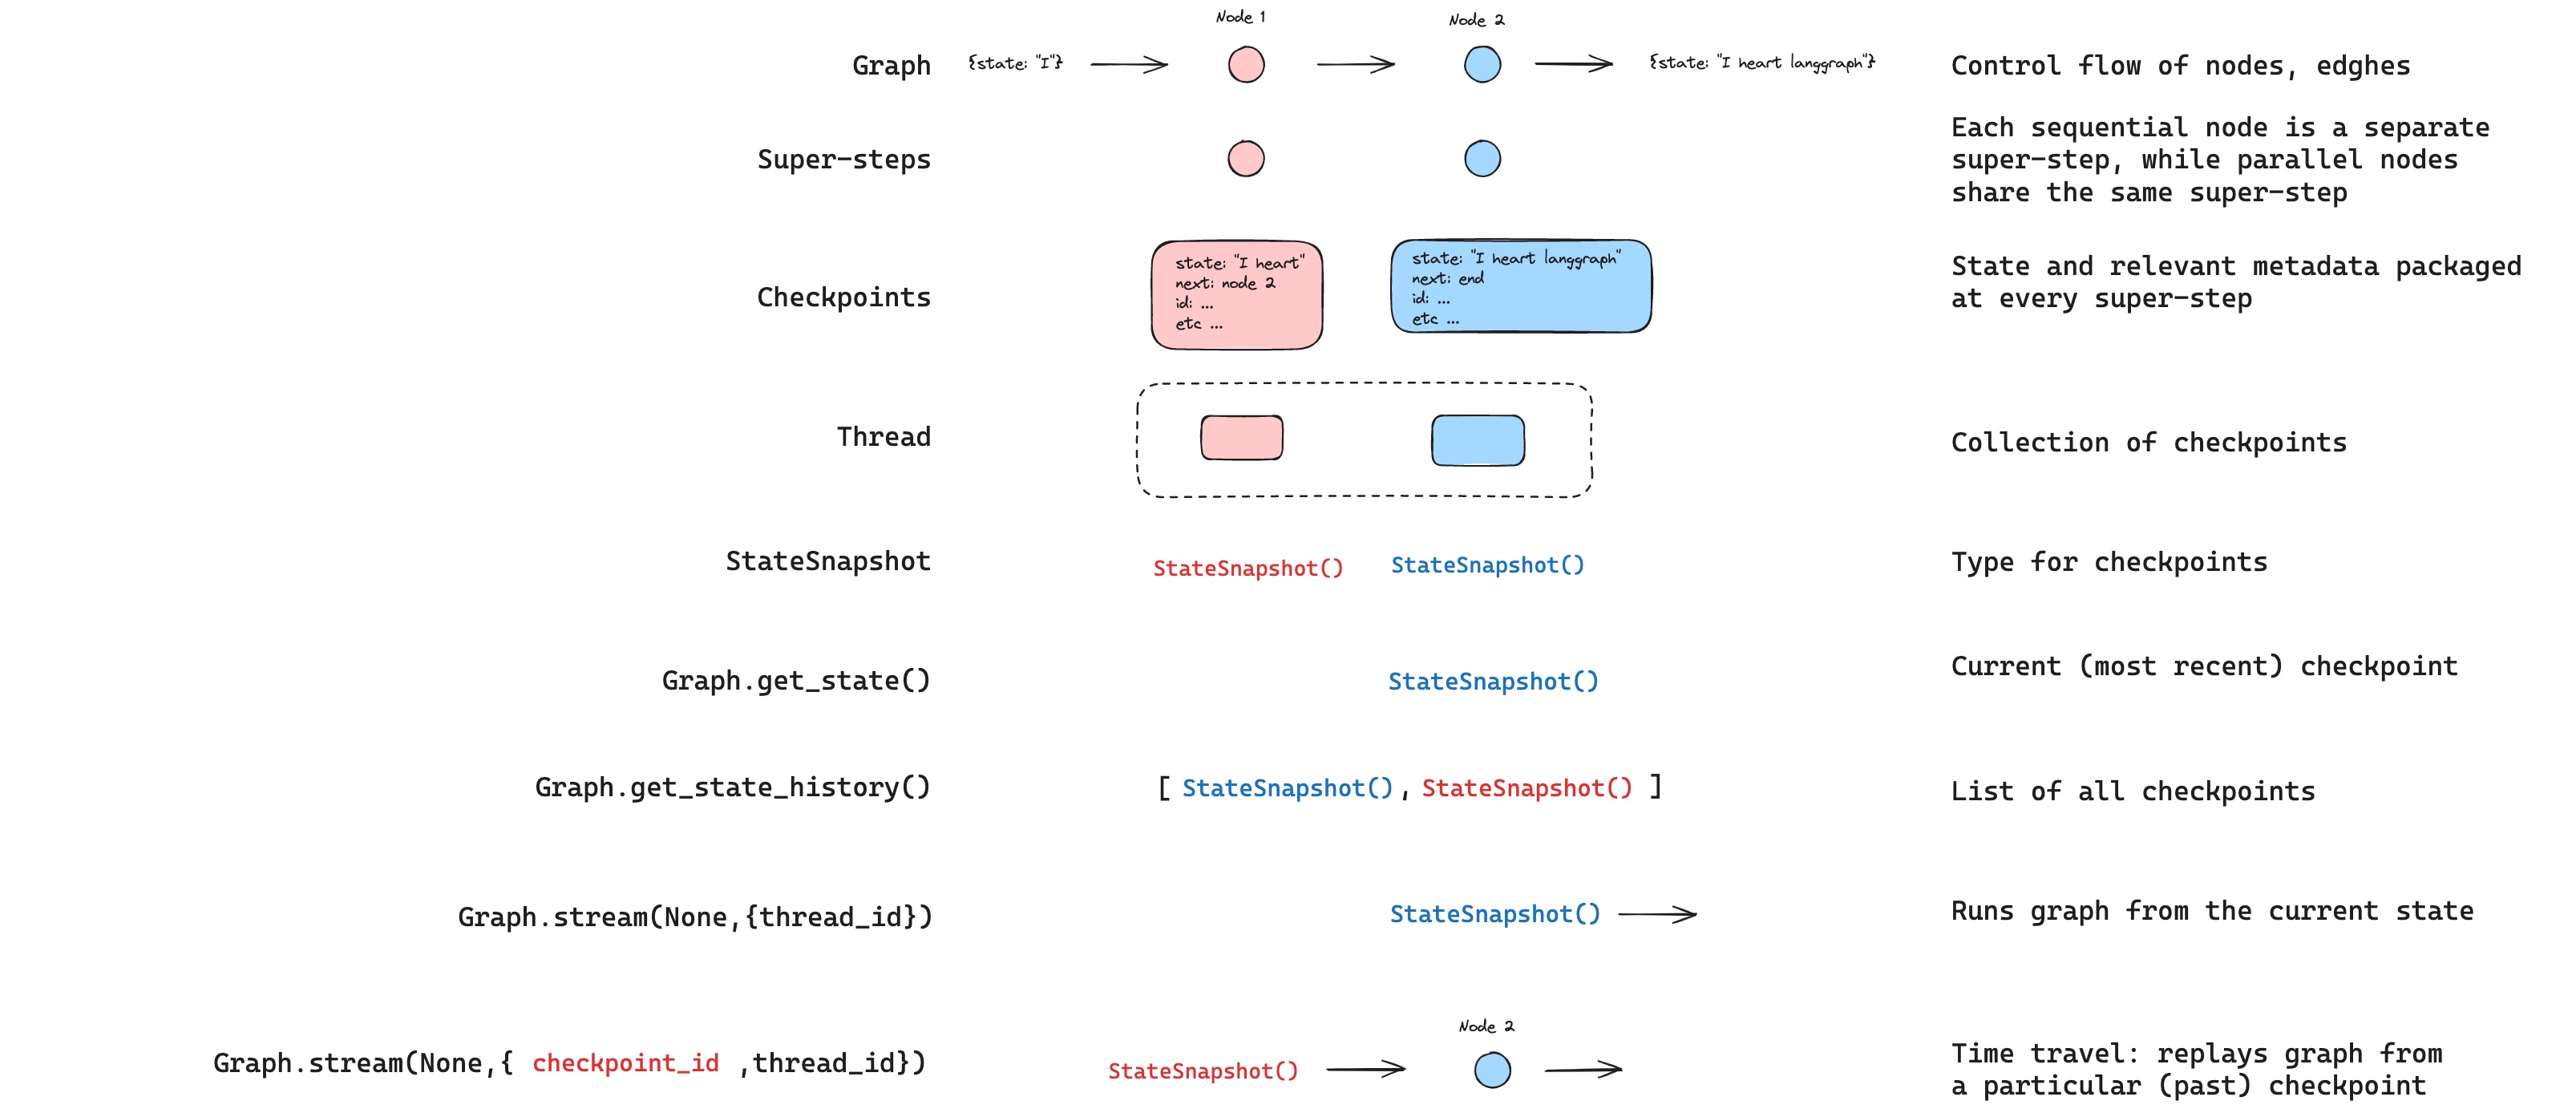

Let's look back at the step that recieved human input!

In [ ]:
to_replay = all_states[-2]

Look at the state.

In [ ]:
to_replay.values

We can see the next node to call.

In [ ]:
to_replay.next

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [ ]:
to_replay.config

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [ ]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input! This is forking.

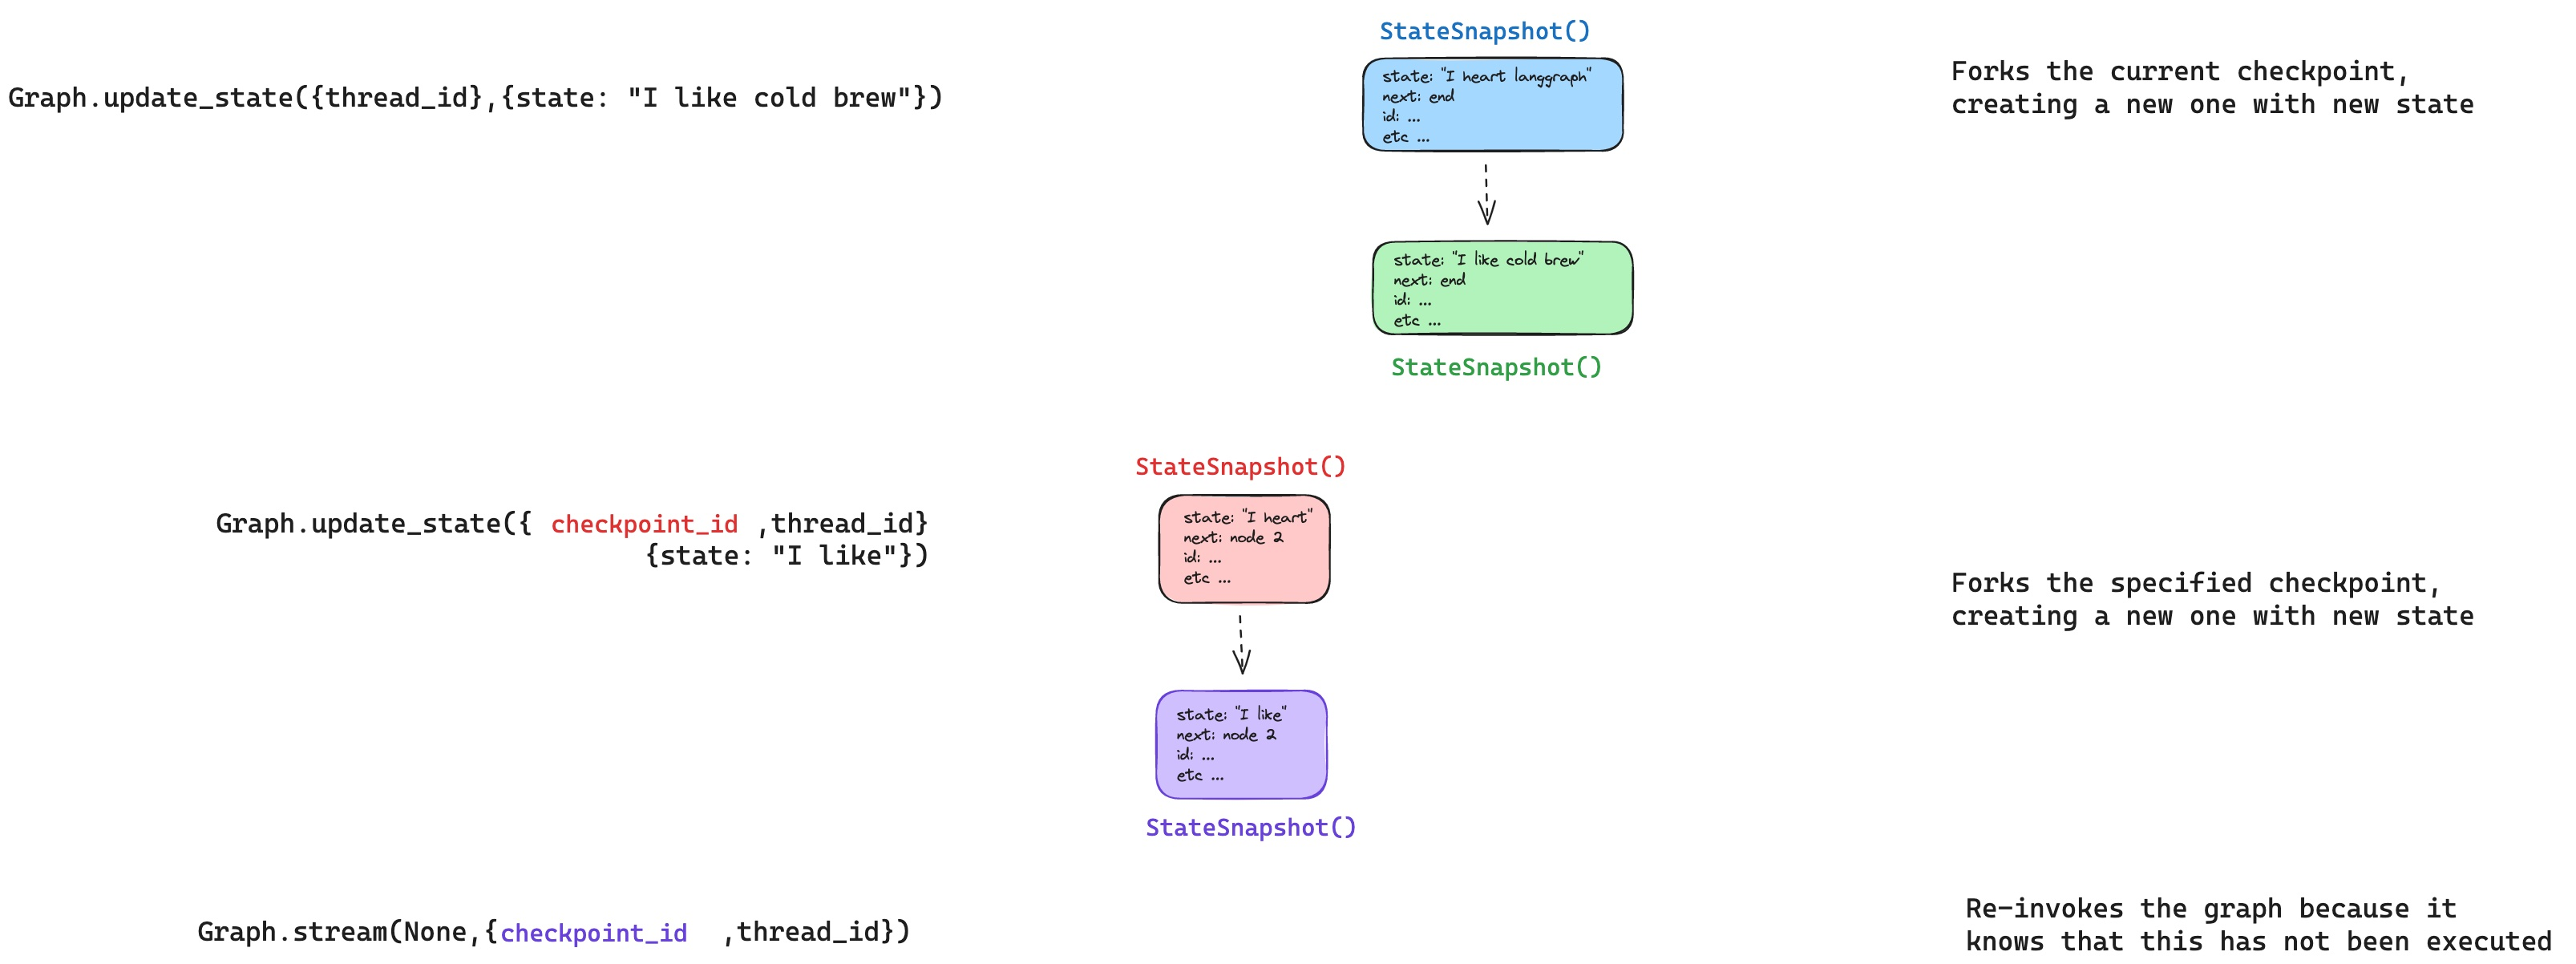

In [ ]:
to_fork = all_states[-2]
to_fork.values["messages"]

Again, we have the config.

In [ ]:
to_fork.config

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [ ]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [ ]:
fork_config

We now see a new checkpoint added to the state history (length 6 now, versus 5 above).

In [ ]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)

In [ ]:
all_states[0]

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [ ]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [ ]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

Now, we can see the current state is the end of our agent run.

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

### Time travel with LangGraph API

Our agent is deployed locally to Studio.

We can interact with our agent via the SDK.

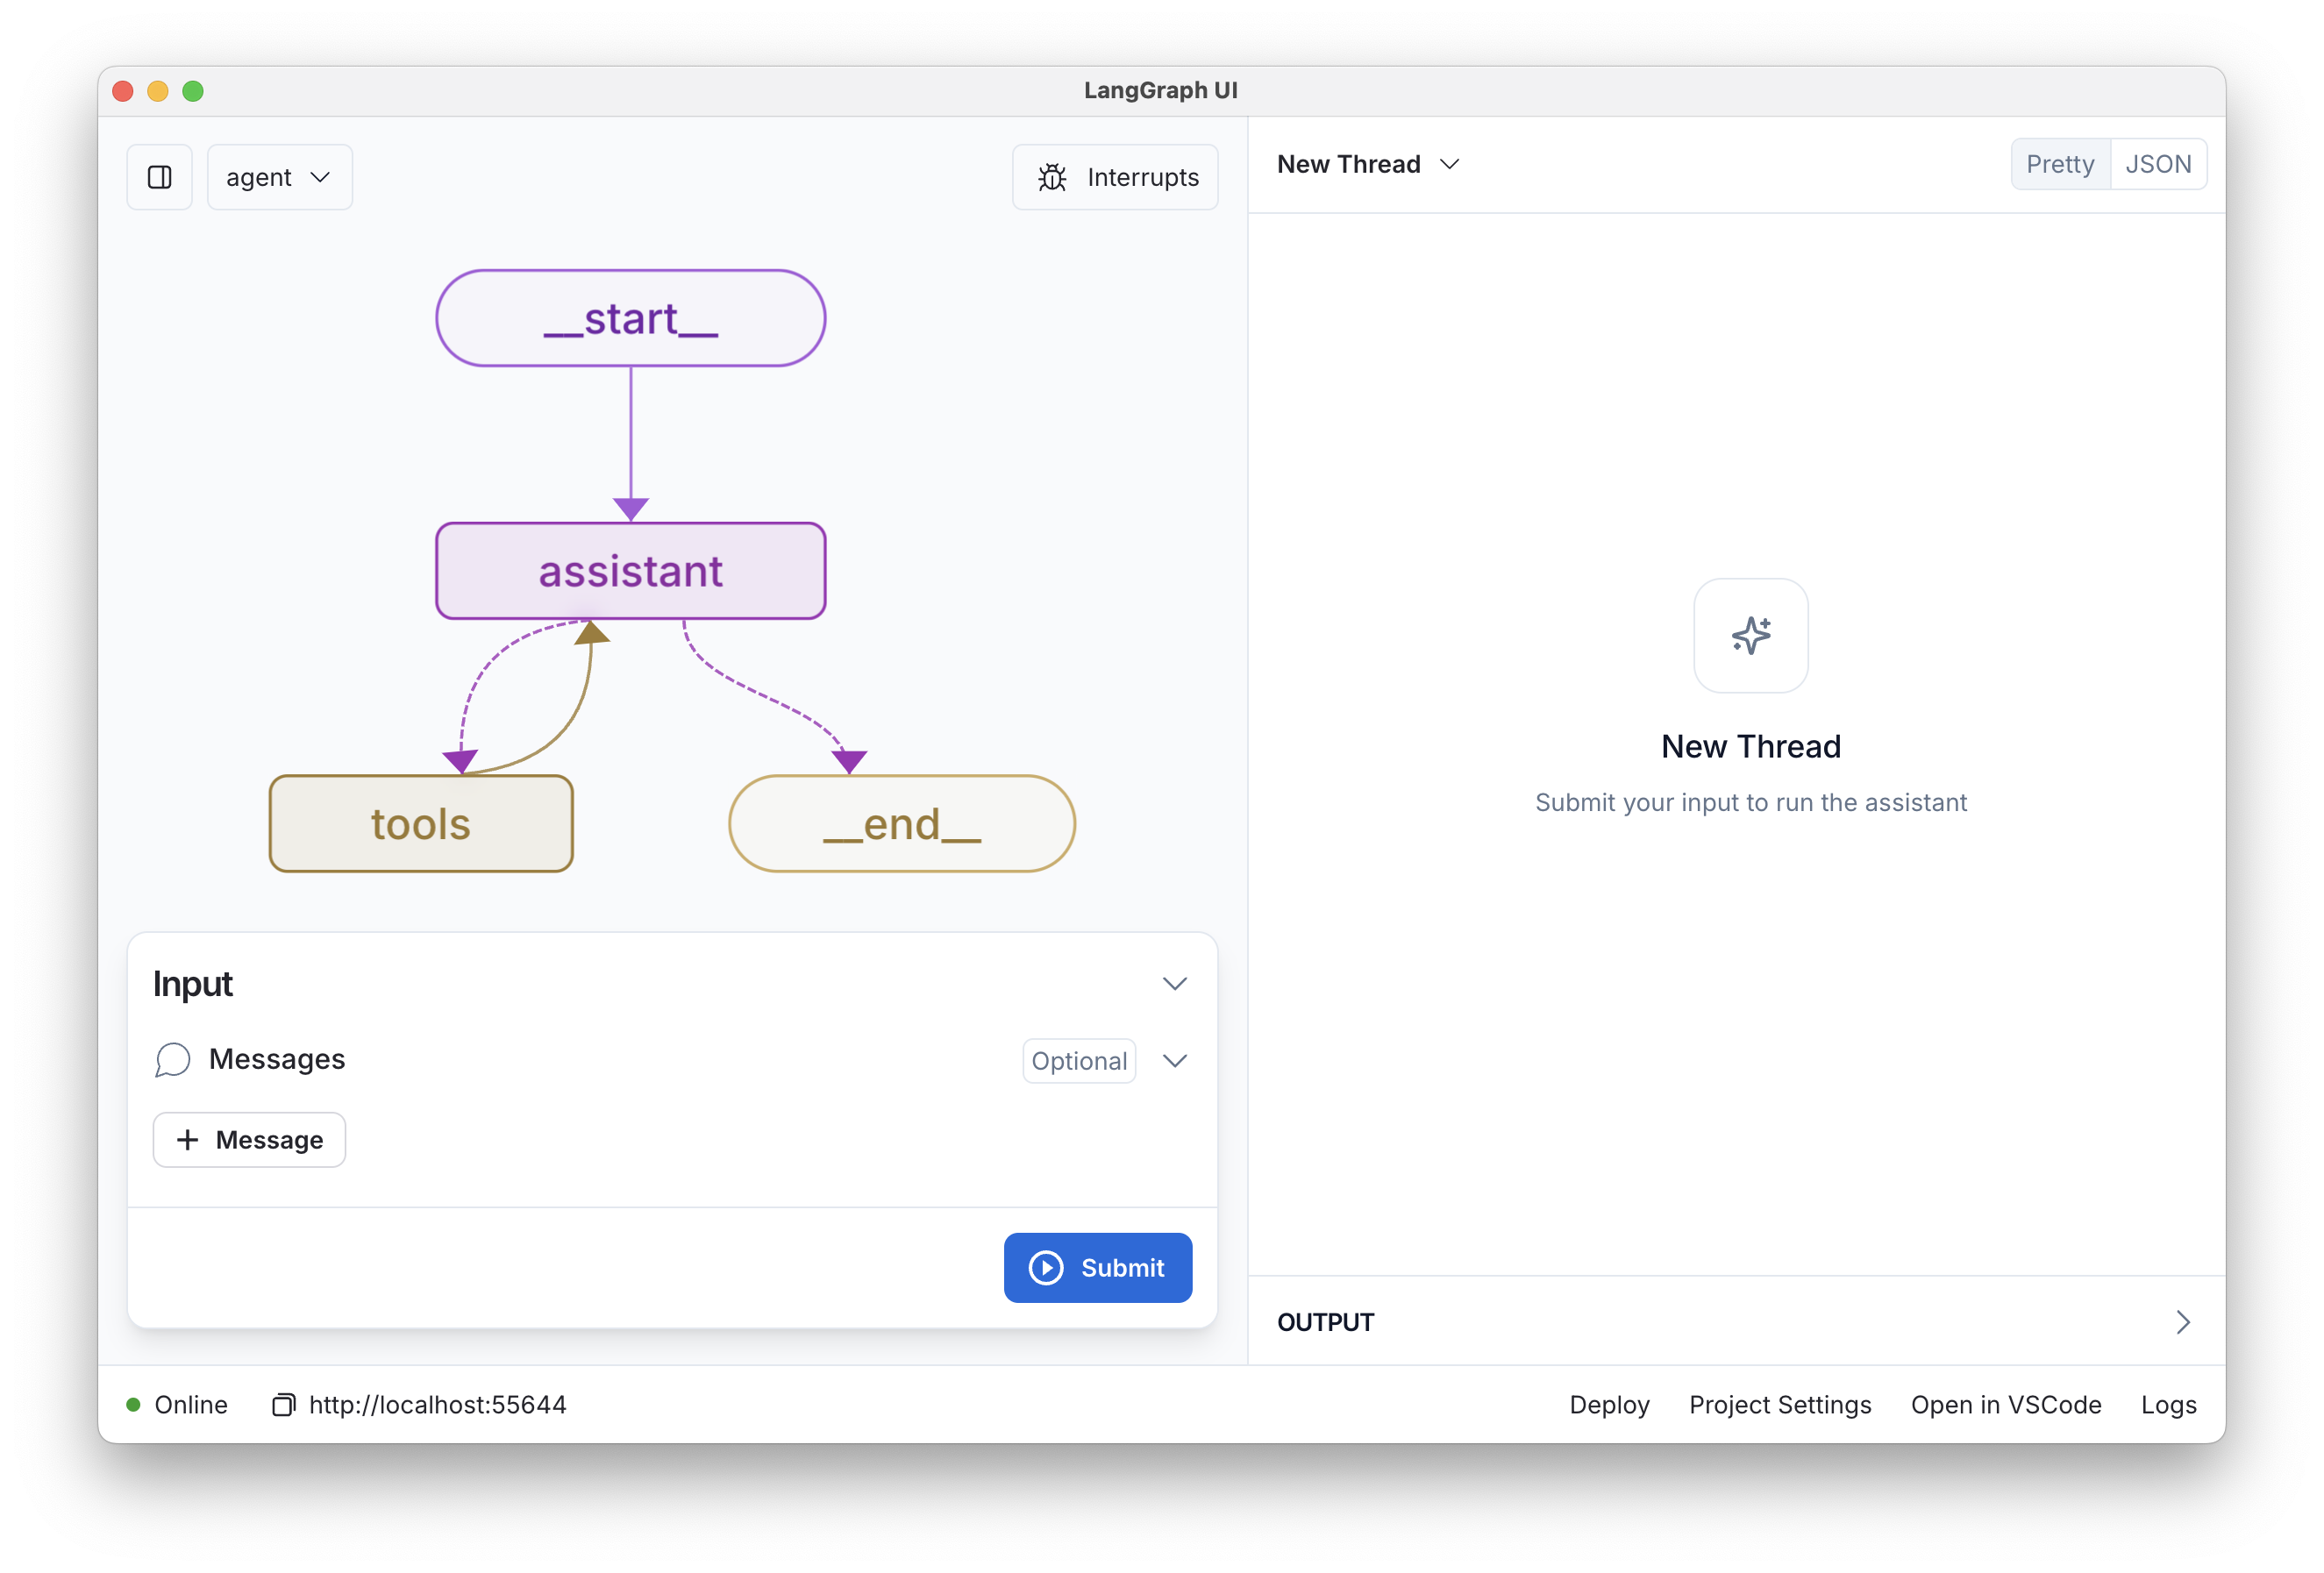

Let's get the URL for the local deployment from Studio.

This URL will change each time you re-load your graphs, so simply select the URL that Studio is displaying. 

The LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

In [9]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:63937")
assistant_id = "agent"

Let's run streaming with `updates`.

This streams updates to the state of the graph after each node is called.

In [11]:
from langchain_core.messages import HumanMessage

initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id,
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_KMByfdHqeBUmIP1O5xEGXaZ1', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a2ff031fb5'}, 'type': 'ai', 'name': None, 'id': 'run-fc483e4e-2e65-4d73-b028-2bb47255c02b', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_KMByfdHqeBUmIP1O5xEGXaZ1', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '01bd2e53-4b5d-4646-9b4e-b5286e76e497', 'tool_call_id': 'call_KMByfdHqeBUmIP1O5xEGXaZ1', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

Let's get the same step as we worked with above, the human input.

In [22]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '5caa3843-f510-47f6-b694-6d5cb5a01e6c',
   'example': False}]}

In [27]:
to_fork['values']['messages'][0]['id']

'5caa3843-f510-47f6-b694-6d5cb5a01e6c'

In [13]:
to_fork['next']

['assistant']

In [14]:
to_fork['checkpoint_id']

'1ef6648c-e22f-6ee2-8000-2c454236d78f'

Let's edit the state.

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [29]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}
forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [30]:
forked_config

{'configurable': {'thread_id': '7313160f-294d-494e-91f4-b8420246a95e',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6649e-6c2c-6a63-8001-588eb9593a54'},
 'checkpoint_id': '1ef6649e-6c2c-6a63-8001-588eb9593a54'}

In [31]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '5caa3843-f510-47f6-b694-6d5cb5a01e6c',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e80dd5c8-afbb-55cf-ae90-2833c1adb99a',
   'name': 'assistant',
   'error': None,
   'interrupts': []}],
 'metadata': {'step': 1,
  'source': 'update',
  'writes': {'__start__': {'messages': {'id': '5caa3843-f510-47f6-b694-6d5cb5a01e6c',
     'name': None,
     'type': 'human',
     'content': 'Multiply 3 and 3',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}}},
  'graph_id': 'agent'},
 'created_at': '2024-08-29T21:01:46.194584+00:00',
 'checkpoint_id': '1ef6649e-6c2c-6a63-8001-588eb9593a54',
 'parent_checkpoint_id': '1ef6648c-e22f-6ee2-8000-2c454236d78f'}

To rerun, we pass in the `checkpoint_id`.

In [32]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id,
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_9vVWWMAceDgKgn9GdToicHlP', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-46c2a2c6-b98f-4f36-8265-f13edf65cd1a', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_9vVWWMAceDgKgn9GdToicHlP', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '04c24b3e-f640-42db-8edf-a062c3cc2eee', 'tool_call_id': 'call_9vVWWMAceDgKgn9GdToicHlP', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

### LangGraph Studio

Let's look more into time travel / forking in Studio using `assistant/agent.py`.